In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline

dead_volume_time = 0.6
f_blank = pd.read_csv('DAD1 A 210 nm blank.csv').to_numpy()
retention_time = f_blank[1:,0]
intensity_blank_data = f_blank[1:,1]
INTERNAL_STANDARD_RETENTION_TIME = 1.77 #min
PEAK_WIDTH = 0.04 #min
DETECTION_LIMIT = 20

test_1 = pd.read_csv('DAD1 A 210 nm test1.csv').to_numpy()
intensity_raw_data = test_1[1:,1]

def integration(x,y):
    #interpolation
    fn = UnivariateSpline(x, y,k=5)

    results = quad(fn,x[0],x[-1])[0]
    return results

In [2]:
# Calculate baseline
processed_data = intensity_raw_data-intensity_blank_data
base_data = []
for i in range(len(processed_data)):
    if abs(processed_data[i])<=3:
        base_data.append(processed_data[i])
base_intensity = np.average(base_data)



## discard dead volume

time_index = 0
for i in range(len(retention_time)):
    time_index = i
    if retention_time[i]>=dead_volume_time:
        break

print(time_index)

retention_time = retention_time[time_index:]
processed_data = processed_data[time_index:]

1438


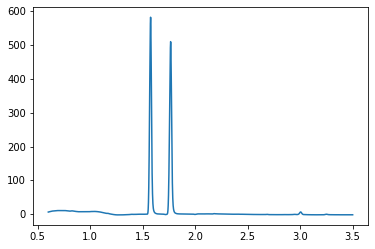

In [3]:
diff = np.diff(processed_data)
scale = max(processed_data)/max(diff)
diff = diff*scale


# calculate base derivatives

base_diff_data = []
for i in range(len(diff)):
    if abs(diff[i])<=1:
        base_diff_data.append(diff[i])

base_diff = np.average(base_diff_data)
plt.plot(retention_time,processed_data)
plt.show()

2287
1.54 1.63625
2741
1.73 1.8258333333333332


(1.5, 1.8)

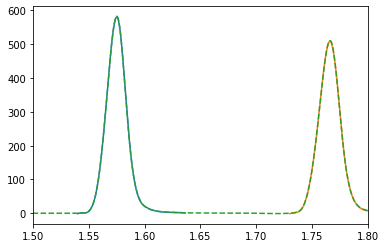

In [4]:
#picking out peaks

data_process_index = 0
maxima = []
maximum_retention_time = []
peak_area_min = []

for i in range(len(processed_data)):
    already_processed = data_process_index >= i
    if already_processed:
        pass
    else:
        if processed_data[i]-base_intensity >= DETECTION_LIMIT:
            print((i))
            # find a peak who has intensity greater than 5
            search_index_left = i
            search_index_right = i
            while abs(diff[search_index_left])>=base_diff+ 0.3 and processed_data[search_index_left] >= base_intensity:
                search_index_left -= 1
            while (abs(diff[search_index_right])>=base_diff+ 0.3 or processed_data[search_index_right]>=DETECTION_LIMIT) \
                    and processed_data[search_index_right] >=  base_intensity:
                search_index_right += 1
            print(retention_time[search_index_left],retention_time[search_index_right])
            data_process_index = search_index_right

            #current peak analysis
            current_peak_time = retention_time[search_index_left:search_index_right+1]
            current_peak_intensity = processed_data[search_index_left:search_index_right+1]
            try:
                fn = UnivariateSpline(current_peak_time, current_peak_intensity)
                current_peak_intensity_spline = fn(current_peak_time)
                plt.plot(current_peak_time,current_peak_intensity_spline)
            except:
                pass
            # find the peak max and time

            max_int_point = 0
            max_int_time = 0

            for i in range(len(current_peak_intensity)):
                if current_peak_intensity[i]>=max_int_point:
                    max_int_time = current_peak_time[i]
                    max_int_point = current_peak_intensity[i]

            maximum_retention_time.append(max_int_time)
            maxima.append(max_int_point)

            #
            # #integrate
            try:
                current_peak_intensity -= base_intensity
                peak_area_min.append(integration(current_peak_time,current_peak_intensity))
            except:
                pass
peak_area_sec = []
for area in peak_area_min:
    peak_area_sec.append(area*60)
plt.plot(retention_time,processed_data,'--')
plt.xlim(1.5,1.8)

In [5]:
## Recognize peaks
internal_standard_retention_time = 0
internal_standard_peak_area = 0
for i in range(len(maximum_retention_time)):
    if abs(maximum_retention_time[i]-INTERNAL_STANDARD_RETENTION_TIME)<=PEAK_WIDTH:
        internal_standard_retention_time = maximum_retention_time[i]
        internal_standard_peak_area = peak_area_min[i]
    else:
        pass

#ratio calculation
peak_ratio = []
for area in peak_area_min:
    peak_ratio.append(area/internal_standard_peak_area)

peak_ratio




[1.0481843693481832, 1.0]